In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [ ]:
df = pd.read_csv('gold.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format='%d/%m/%y')

df.set_index('<DATE>', inplace=True)
df

,<TICKER>,<PER>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,,,,
2020-01-01,comex.GC,D,0,1521.0,1524.0,1520.5,1521.0,5291
2020-01-02,comex.GC,D,0,1520.9,1534.0,1519.7,1531.3,236447
2020-01-03,comex.GC,D,0,1531.3,1556.6,1531.3,1555.2,383128
2020-01-05,comex.GC,D,0,1562.7,1590.9,1562.3,1571.6,42728
2020-01-06,comex.GC,D,0,1571.5,1582.5,1562.7,1565.7,452446
...,...,...,...,...,...,...,...,...
2022-12-27,comex.GC,D,0,1809.6,1841.9,1808.4,1820.6,152921
2022-12-28,comex.GC,D,0,1820.5,1822.3,1804.2,1812.5,106251
2022-12-29,comex.GC,D,0,1812.5,1827.3,1811.2,1821.9,99420


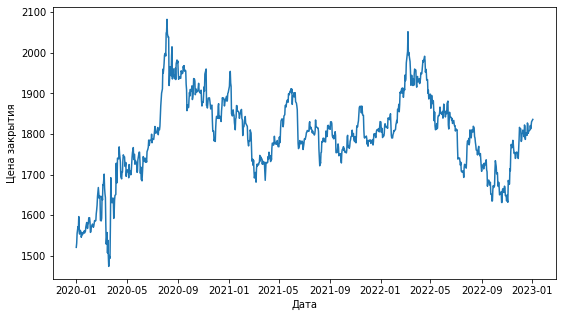

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(df['<CLOSE>'])
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

In [ ]:
days = 60

dff = df.filter(['<CLOSE>'])
data = dff.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


train_size = math.ceil(.8 * len(data))
train = scaled_data[:train_size, :]
test = scaled_data[train_size-days:, :]

print(scaled_data.shape,train.shape,test.shape)

(934, 1) (748, 1) (246, 1)


In [ ]:
x_train = [] 
y_train = []
for i in range(days, len(train)):
  x_train.append(train[i-days:i,0])
  y_train.append(train[i, 0])

x_test = [] 
y_test = []
for i in range(days, len(test)):
  x_test.append(test[i-days:i,0])
  y_test.append(test[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(186, 60, 1)

In [ ]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape= (x_train.shape[1],1)))
model.add(GRU(units=25))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
69/69 [==============================] - 9s 57ms/step - loss: 0.0979
Epoch 2/10
69/69 [==============================] - 4s 52ms/step - loss: 0.0353
Epoch 3/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0289
Epoch 4/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0260
Epoch 5/10
69/69 [==============================] - 3s 49ms/step - loss: 0.0255
Epoch 6/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0240
Epoch 7/10
69/69 [==============================] - 3s 49ms/step - loss: 0.0247
Epoch 8/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0245
Epoch 9/10
69/69 [==============================] - 3s 47ms/step - loss: 0.0238
Epoch 10/10
69/69 [==============================] - 3s 47ms/step - loss: 0.0229


6/6 [==============================] - 1s 13ms/step


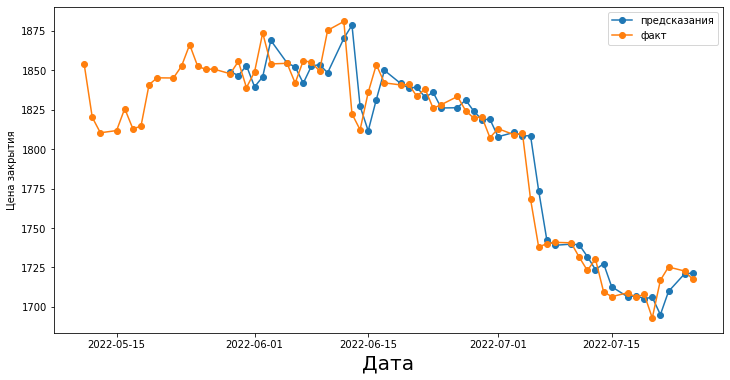

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 50)            7950      
                                                                 
 gru_5 (GRU)                 (None, 25)                5775      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________
            <CLOSE>         pred
<DATE>                          
2022-12-29   1821.9  1812.341431
2022-12-30   1830.1  1819.005371
2023-01-02   1835.8  1827.551514
Среднее значение ошибки: 11.653827


In [ ]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

val = dff[-pred.size:]
val['pred'] = pred

plt.figure(figsize=(12,6))
plt.xlabel('Дата',fontsize=20)
plt.ylabel('Цена закрытия')

plt.plot(val['pred'][:50],'-o', label='предсказания')
plt.plot(dff['<CLOSE>'][-pred.size-15:-pred.size+50],'-o', label='факт')
plt.legend()
plt.show()


model.save('model')
model.summary()

print(val.tail(3))
print('Среднее значение ошибки:', mean_absolute_error(val['<CLOSE>'], val['pred']).numpy())